In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [10]:
gdf = gpd.read_file('Data/State/tl_2023_us_state.shp')

gdf = gdf[gdf['NAME'] == 'California']

In [12]:
deep_reload(src)

atlas, graph, cities = src.experiment.load_graphs()

In [190]:
deep_reload(src)

sg = src.experiment.non_proprietary_network(graph)

In [191]:
deep_reload(src)

sg = src.experiment.prepare_graph(sg)

In [192]:
deep_reload(src)

veh = src.routing.ConstrainedVehicle(
    n_cases = 100,
    risk_attitude = (0, 1),
    ess_capacity = 65 * 3.6e6 * .8,
    efficiency = 626.5,
    rate = 55e3,
)

station = src.routing.Station(
    veh,
    reliability = .75,
    rate = 55e3,
    seed = 125897,
)

In [193]:
deep_reload(src)

sg = src.experiment.add_stations(sg, station)

In [194]:
locations = list(cities.nodes)

In [195]:
deep_reload(src)

t0 = time.time()

expectations, values, paths = veh.all_pairs(
    sg,
    nodes = locations,
)

time.time() - t0

 [----------->] (15/15) 100.00%, 0.05 it/s, 322.16 s elapsed, 0.00 s remaining

322.1591272354126

In [196]:
pkl.dump(
    [expectations, values, paths],
    open('Outputs/Bolt_Neutral_Case_Example.pkl', 'wb')
)

In [197]:
{k: v['time'].mean() / 3600 for k, v in values['Fresno'].items() if 'station' not in k}

{'Fresno': 0.0,
 'Bakersfield': 1.6367222152847143,
 'Stockton': 2.0871465791153283,
 'San Jose': 2.7082465034965044,
 'Sacramento': 5.820448423104674,
 'San Francisco': 5.3536586265627335,
 'Los Angeles': 6.322148976023974,
 'Chico': 7.536328934953933,
 'I-80 to Reno (State Line)': 7.849658893190144,
 'San Diego': 8.4107838897214,
 'Redding': 8.779168366355867,
 'I-15 to Las Vegas (State Line)': 8.878424981268735,
 'I-10 to Phoenix (State Line)': 12.809374347874343,
 'Yreka': 13.313503000471762,
 'Crescent City': 15.58479251998002}

In [152]:
deep_reload(src)

t0 = time.time()

expectations, values, paths = veh.routes(
    sg,
    origins = origins,
    destinations = locations,
    return_paths = True
)

time.time() - t0

8.585534572601318

In [153]:
{k: v['time'].mean() / 3600 for k, v in values.items() if 'station' not in k}

{'Fresno': 0.0,
 'Bakersfield': 4.636722215284713,
 'Stockton': 5.087146579115329,
 'San Jose': 5.708246503496504,
 'Sacramento': 5.820448423104674,
 'Los Angeles': 6.322148976023974,
 'San Francisco': 6.3229777479464975,
 'Chico': 10.463616359335107,
 'I-80 to Reno (State Line)': 10.760379925629925,
 'San Diego': 11.339718212343218,
 'Redding': 11.706455790737044,
 'I-15 to Las Vegas (State Line)': 11.878424981268733,
 'I-10 to Phoenix (State Line)': 12.809374347874343,
 'Yreka': 16.240790424852936,
 'Crescent City': 18.512079944361197}

In [187]:
pkl.dump(
    [expectations, values, paths],
    open('Outputs/Bolt_Fresno_Cautious.pkl', 'wb')
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


IndexError: list index out of range

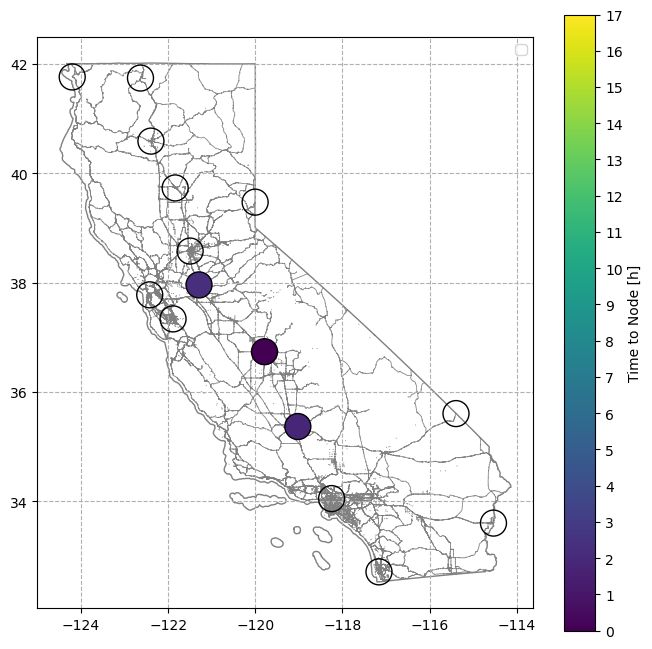

In [20]:
deep_reload(src)

plot_graph = src.graph.subgraph(sg, list(cities.nodes))

paths_c = [v[1:-1] for k, v in paths.items() if k in cities.nodes]
plot_graph_c = src.graph.subgraph(
    sg, list(np.unique(np.concatenate(paths_c)))
)

path_values_avg = {}

for target, value in values.items():

    path_values_avg[target] = {}

    for key, val in value.items():

        path_values_avg[target][key] = src.routing.super_quantile(val, (0, 1))

fig, ax  = plt.subplots(figsize = (8,8))

key = 'time'

for source, node in plot_graph._node.items():

		try:
			node['plot'] = path_values_avg[source][key] / 3.6e3

		except:
			node['plot'] = np.nan

gdf.plot(ax = ax, ec = 'gray', fc = 'none')

kwargs = {
    'show_links': False,
    'node_field': 'plot',
    'scatter': {
        's': 350,
        'ec': 'k',
        'zorder': 2,
        'vmin': 0,
        'vmax': 17,
    },
    'colorbar': {
        'label': 'Time to Node [h]',
        'ticks': range(0, 18),
    },
    'cmap': src.figures.colormap('viridis'),
}

src.figures.plot_graph(plot_graph, ax = ax, **kwargs)

kwargs = {
		'node_field': None,
		'scatter': {
			's': .5,
			'ec': 'none',
            'fc': 'gray',
            'zorder': 0,
		},
		'show_links': False,
	}
src.figures.plot_graph(atlas, ax = ax, **kwargs)

kwargs = {
    'scatter': {
        's': 250,
        'ec': 'k',
        'fc': 'k',
        'label': 'Charging Stations Utilized',
        'zorder': 1,
        'marker': '^',
    },
    'show_links': False,
    'axes': {
        'facecolor': 'whitesmoke',
    }
}

src.figures.plot_graph(plot_graph_c, ax = ax, **kwargs)

_ = ax.grid(ls = '--')
legend = ax.legend()
legend.legendHandles[0]._sizes = [100]

# fig.savefig('Paper/figs/R_California_Bolt_Fresno_Cautious.png', bbox_inches = 'tight', dpi = 300)

In [190]:
{k: v['time'] / 3600 for k, v in path_values_avg.items() if 'station' not in k}

{'Fresno': 0.0,
 'Bakersfield': 1.818580239205238,
 'Stockton': 2.3190517545725875,
 'Sacramento': 5.11539661947361,
 'San Jose': 5.489952518821178,
 'San Francisco': 5.717168694336306,
 'Los Angeles': 6.487153132617651,
 'I-80 to Reno (State Line)': 9.819831921511726,
 'Chico': 11.004503762298857,
 'San Diego': 11.404654946114759,
 'I-10 to Phoenix (State Line)': 16.375239381978357}

In [94]:
{k: v['time_nc'] / 3600 for k, v in path_values_avg.items() if 'station' not in k}

{'Fresno': 0.0,
 'Bakersfield': 1.818580239205238,
 'Stockton': 2.3190517545725875,
 'Sacramento': 3.125707124665461,
 'San Jose': 3.0724786324786337,
 'San Francisco': 3.4546262726471064,
 'Los Angeles': 3.69127664002664,
 'Chico': 4.886171247733754,
 'I-80 to Reno (State Line)': 5.236370862933366,
 'San Diego': 5.869172817922828,
 'Redding': 6.267103949291456,
 'I-15 to Las Vegas (State Line)': 6.598255517630515,
 'I-10 to Phoenix (State Line)': 7.56597149763817,
 'Yreka': 7.881089674214683,
 'Crescent City': 9.924029431216944}

In [28]:
{k: v['time'] / 3600 for k, v in path_values_avg.items() if 'station' not in k}

{'Fresno': 0.0,
 'Bakersfield': 1.8185802392052384,
 'Stockton': 2.3190517545725915,
 'San Jose': 3.1718551485373503,
 'Sacramento': 3.418045700078774,
 'San Francisco': 3.8699938516401367,
 'Los Angeles': 4.454643334751668,
 'Chico': 5.653357454344395,
 'I-80 to Reno (State Line)': 6.0614637638640305,
 'San Diego': 7.09528321295362,
 'Redding': 7.115529306675718,
 'I-15 to Las Vegas (State Line)': 7.949343328246323,
 'Yreka': 9.355659174872667,
 'I-10 to Phoenix (State Line)': 9.502401945764017,
 'Crescent City': 12.720386049793047}

In [29]:
{k: v['time_nc'] / 3600 for k, v in path_values_avg.items() if 'station' not in k}

{'Fresno': 0.0,
 'Bakersfield': 1.8185802392052384,
 'Stockton': 2.3190517545725915,
 'San Jose': 3.009162781662782,
 'Sacramento': 3.1022296954588615,
 'San Francisco': 3.4114510643677307,
 'Los Angeles': 3.69127664002664,
 'Chico': 4.886171247733754,
 'I-80 to Reno (State Line)': 5.187902876444547,
 'San Diego': 5.88966898841899,
 'Redding': 5.9311873889999,
 'I-15 to Las Vegas (State Line)': 6.5748180176305215,
 'Yreka': 7.564757850174525,
 'I-10 to Phoenix (State Line)': 7.559964657256322,
 'Crescent City': 10.116834997564164}

In [3]:
# Graph containing DC chargers

with open('Data/AFDC/evse_stations.json', 'r') as file:
    evse = json.load(file)

In [4]:
stations_raw = []

for station in evse['fuel_stations']:

    checks = (
        station['state'] == 'CA',
        station['ev_dc_fast_num'] is not None,
        station['access_code'] == 'public',
        station['status_code'] == 'E',
    )

    if all(checks):

        stations_raw.append(station)

In [5]:
df_stations = pd.DataFrame.from_dict(stations_raw)

In [6]:
df_s_t = df_stations[df_stations['ev_network'] == 'Tesla']
df_s_np = df_stations[df_stations['ev_network'] != 'Tesla']
df_s_np = df_s_np[df_s_np['ev_network'] != 'RIVIAN_ADVENTURE']
df_s_cp = df_stations[df_stations['ev_network'] == 'ChargePoint Network']
df_s_ea = df_stations[df_stations['ev_network'] == 'Electrify America']
df_s_ev = df_stations[df_stations['ev_network'] == 'eVgo Network']

df_n = [df_s_t, df_s_np, df_s_cp, df_s_ea, df_s_ev]

In [217]:
[df['ev_dc_fast_num'].sum() for df in df_n]

[6277, 3667, 478, 1086, 1199]

In [219]:
[df.shape[0] for df in df_n]

[403, 1425, 475, 252, 357]

In [218]:
[df['ev_dc_fast_num'].sum() / df.shape[0] for df in df_n]

[15.575682382133994,
 2.5733333333333333,
 1.0063157894736843,
 4.309523809523809,
 3.358543417366947]

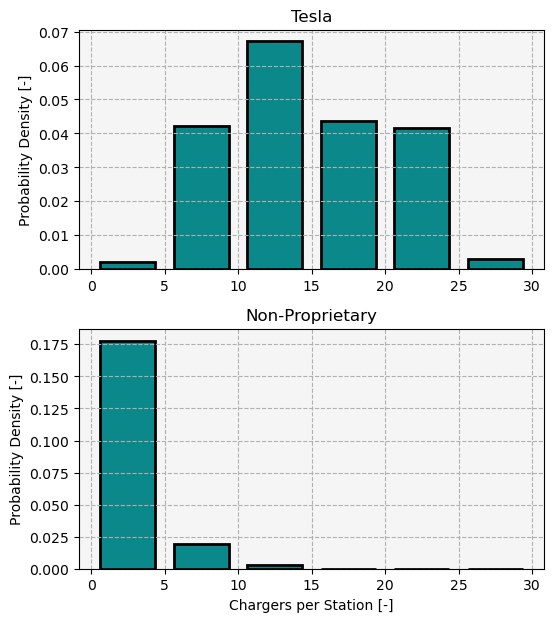

In [249]:
cp_p_s = [df['ev_dc_fast_num'] for df in df_n][:2]

bins = np.arange(0, 35, 5)

kwargs = {
    'rwidth': .75,
    'density': True,
    'bins': bins,
    'fc': 'xkcd:dark cyan',
    'ec': 'k',
    'lw': 2,
}

fig, ax = plt.subplots(2, 1, figsize = (6, 7), gridspec_kw = {'hspace': .25})

ax[0].hist(cp_p_s[0], **kwargs)

ax[0].set(**{
    'facecolor': 'whitesmoke',
    'title': 'Tesla',
    # 'xlabel': 'Chargers per Station [-]',
    'ylabel': 'Probability Density [-]',
})
ax[0].grid(**{'ls': '--'})

ax[1].hist(cp_p_s[1], **kwargs)

ax[1].set(**{
    'facecolor': 'whitesmoke',
    'title': 'Non-Proprietary',
    'xlabel': 'Chargers per Station [-]',
    'ylabel': 'Probability Density [-]',
})
ax[1].grid(**{'ls': '--'})

fig.savefig('Paper/figs/California_Charger_Network_Histograms.png', bbox_inches = 'tight', dpi = 300)

In [216]:
df_s_t.keys()

Index(['access_code', 'access_days_time', 'access_detail_code',
       'cards_accepted', 'date_last_confirmed', 'expected_date',
       'fuel_type_code', 'groups_with_access_code', 'id', 'open_date',
       'owner_type_code', 'status_code', 'restricted_access',
       'maximum_vehicle_class', 'station_name', 'station_phone', 'updated_at',
       'facility_type', 'geocode_status', 'latitude', 'longitude', 'city',
       'intersection_directions', 'plus4', 'state', 'street_address', 'zip',
       'country', 'bd_blends', 'cng_dispenser_num', 'cng_fill_type_code',
       'cng_psi', 'cng_renewable_source', 'cng_total_compression',
       'cng_total_storage', 'cng_vehicle_class', 'cng_has_rng',
       'e85_blender_pump', 'e85_other_ethanol_blends', 'ev_connector_types',
       'ev_dc_fast_num', 'ev_level1_evse_num', 'ev_level2_evse_num',
       'ev_network', 'ev_network_web', 'ev_other_evse', 'ev_pricing',
       'ev_renewable_source', 'ev_workplace_charging', 'hy_is_retail',
       'hy_pres

In [209]:
u, uc = np.unique(df_stations['ev_network'], return_counts = True)

u, uc, uc.sum(), uc.sum() - 403 - 78

(array(['7CHARGE', 'Blink Network', 'CHARGELAB', 'CIRCLE_K',
        'ChargePoint Network', 'EV Connect', 'EVCS', 'EVGATEWAY',
        'EVRANGE', 'Electrify America', 'FLO', 'LOOP', 'Non-Networked',
        'POWERFLEX', 'RIVIAN_ADVENTURE', 'SHELL_RECHARGE', 'SWTCH',
        'Tesla', 'Volta', 'eVgo Network'], dtype=object),
 array([  5,  11,   2,   7, 475,  36,  63,  14,   4, 252,   1,   1, 131,
         11,  78,  37,   1, 403,  17, 357]),
 1906,
 1425)

In [7]:
node_attributes = {
    'x': 'lambda n: n["longitude"]',
    'y': 'lambda n: n["latitude"]',
    'n_dcfc': 'lambda n: n["ev_dc_fast_num"]',
    'n_acl2': 'lambda n: n["ev_level2_evse_num"]',
    'network': 'lambda n: n["ev_network"]',
    'name': 'lambda n: n["station_name"]',
    'address': 'lambda n: n["street_address"]',
    'city': 'lambda n: n["city"]',
    'state': 'lambda n: n["state"]',
    'zip': 'lambda n: n["zip"]',
    'access_code': 'lambda n: n["access_code"]',
    'status_code': 'lambda n: n["status_code"]',
    'type': 'lambda n: "station"',
}

nlg = src.graph.nlg_from_dataframe(df_stations, node_attributes)

graph_station = src.graph.graph_from_nlg(nlg)

mapping = {n: f'station_{n}' for n in graph_station.nodes}

graph_station = nx.relabel_nodes(graph_station, mapping)

In [8]:
tesla = [k for k, v in graph_station._node.items() if v['network'] in ['Tesla', 'RIVIAN_ADVENTURE']]

npr = (
    [k for k, v in graph_station._node.items() if v['network'] not in \
     ['Tesla', 'RIVIAN_ADVENTURE']]
)

graph_station_t = src.graph.subgraph(graph_station, tesla)

graph_station_npr = src.graph.subgraph(graph_station, npr)

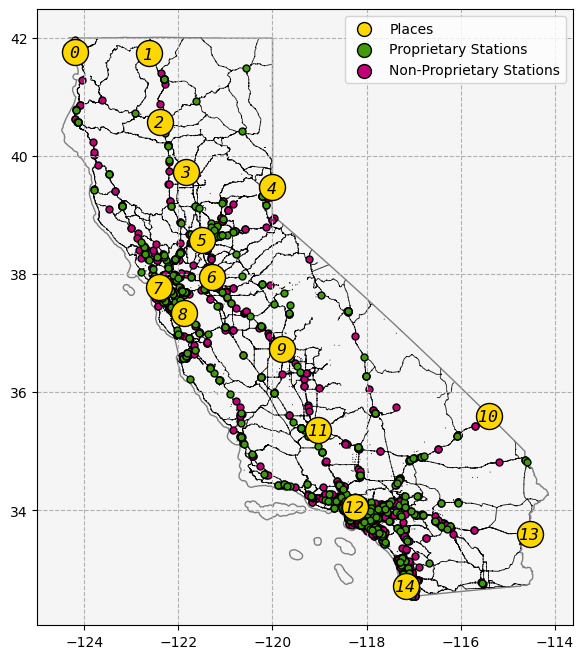

In [15]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (8, 8), squeeze = False)

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 350,
			'ec': 'k',
            'fc': 'gold',
            'label': 'Places',
            'zorder': 3,
		},
		'show_links': False,
	}

gdf.plot(ax = ax[0, 0], ec = 'gray', fc = 'none')
src.figures.plot_graph(cities, ax = ax[0, 0], **kwargs)
ax[0, 0].legend()
ax[0, 0].grid(ls = '--')

kwargs = {
		'node_field': None,
		'scatter': {
			's': .5,
			'ec': 'none',
            'fc': 'k',
            # 'label': 'Roads',
            'zorder': 0,
		},
		'show_links': False,
	}

# gdf_zones_california.plot(ax = ax[1], ec = 'gray', fc = 'none')
src.figures.plot_graph(atlas, ax = ax[0, 0], **kwargs)
ax[0, 0].legend(markerscale = 10)
ax[0, 0].grid(ls = '--')

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 25,
			'ec': 'k',
            'fc': 'xkcd:grass green',
            'label': 'Proprietary Stations',
            'zorder': 2,
		},
		'show_links': False,
        'axes': {
            'facecolor': 'whitesmoke',
        }
	}

src.figures.plot_graph(graph_station_t, ax = ax[0, 0], **kwargs)

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 25,
			'ec': 'k',
            'fc': 'xkcd:magenta',
            'label': 'Non-Proprietary Stations',
            'zorder': 1,
		},
		'show_links': False,
        'axes': {
            'facecolor': 'whitesmoke',
        }
	}

src.figures.plot_graph(graph_station_npr, ax = ax[0, 0], **kwargs)


legend = ax[0, 0].legend()
legend.legendHandles[0]._sizes = [100]
legend.legendHandles[1]._sizes = [100]
legend.legendHandles[2]._sizes = [100]
ax[0, 0].grid(ls = '--')

idx = 0

for k, v in cities._node.items():

    ax[0, 0].text(
        v['x'] - .015, v['y'] - .015, idx,
        horizontalalignment = 'center', verticalalignment = 'center',
        fontfamily = 'monospace', fontsize = 'large', fontstyle = 'italic',
    )

    idx += 1

fig.savefig('Paper/figs/California_Places_Chargers.png', bbox_inches = 'tight', dpi = 300)